# Singing performance assessment

In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
%matplotlib inline
np.random.seed(1234)

## Create balance pairs

- 256 positive pairs + 256 negative pairs

In [2]:
# read files
datapath = './f0data'
per_fail = []
per_pass = []
ref = []

for i in os.listdir(datapath):
    if i.endswith('pass.f0s.txt'):
        per_pass.append(datapath + '/' + i)
    elif i.endswith('fail.f0s.txt'):
        per_fail.append(datapath + '/' + i)
    else:
        ref.append(datapath + '/' + i)

# file name lists
per_pass = sorted(per_pass) # 266
per_fail = sorted(per_fail) # 730
ref = sorted(ref) # 2542

num_pass = len(per_pass)
num_fail = len(per_fail)
num_per = num_pass + num_fail
num_ref = len(ref)

print("Number of pass: ", num_pass)
print("Number of fail: ", num_fail)
print("Number of performances: ", num_per)
print("Number of reference: ", num_ref)

Number of pass:  266
Number of fail:  730
Number of performances:  996
Number of reference:  2542


In [3]:
# randomly choose 266 from 730 fails
pick = np.random.choice(num_fail, num_pass, replace=False)
pick = sorted(pick)

per_fail_pick = np.array(per_fail)[pick] # 266 fail file name lists
per_filename = np.concatenate((per_pass, per_fail_pick)) # 532 performance file name lists

In [4]:
# performance f0 data
# only second column f0 data
# trim zeros from beginning and end
pass_f0 = [np.trim_zeros(np.loadtxt(file)[:,1]) for file in per_pass]
pass_f0 = np.array(pass_f0,dtype='object')
fail_f0 = [np.trim_zeros(np.loadtxt(file)[:,1]) for file in per_fail_pick]
fail_f0 = np.array(fail_f0,dtype='object')

per_f0 = np.concatenate((pass_f0, fail_f0)) # 532 performance f0

In [5]:
# create matching reference file name list
# find 532 reference files that pair with 532 performances
new_ref = ref.copy()
ref_match = [] # 532 reference file name list

for i in per_filename:
    identifier = i.split('per')[0]
    for j in new_ref:
        if j.split('ref')[0] == identifier:
            ref_match.append(j)
            new_ref.remove(j)
            break

## Data prepocessing

- Trim zeros from beginning and end

- Convert f0 to midi

- Resample all singing and reference to same length

In [6]:
# reference f0 data
# only second column f0 data
# trim zeros from beginning and end
ref_f0 = [np.trim_zeros(np.loadtxt(file)[:,1]) for file in ref_match]
ref_f0 = np.array(ref_f0,dtype='object') # 532 performance f0

In [7]:
# convert f0 to midi (0hz stays 0 in midi)
# https://stackoverflow.com/questions/21752989/numpy-efficiently-avoid-0s-when-taking-logmatrix

per_midi = np.copy(per_f0)
for i, f0 in enumerate(per_f0):
    per_midi[i] = 12 * np.ma.log2(f0/440) + 69
    per_midi[i] = per_midi[i].filled(0) # 532 ref midi
    
ref_midi = np.copy(ref_f0)
for i, f0 in enumerate(ref_f0):
    ref_midi[i] = 12 * np.ma.log2(f0/440) + 69
    ref_midi[i] = ref_midi[i].filled(0) # 532 ref midi

In [8]:
# average lenghth of data
length = 0
for i,file in enumerate(per_f0):
    length += len(file)
avg_len_per = int(length/i)
print("average length for performances f0: ", avg_len_per)

length = 0
for i,file in enumerate(ref_f0):
    length += len(file)
avg_len_ref = int(length/i)
print("average length for references f0: ", avg_len_ref)

avg_len = int((avg_len_per + avg_len_ref)/2)
print("average length f0: ", avg_len)

average length for performances f0:  1643
average length for references f0:  1789
average length f0:  1716


In [9]:
# resample performance and reference to average length
per_midi_res = np.copy(per_midi)
for i, item in enumerate(per_midi):
    xp = np.arange(len(item))
    fp = item
    per_midi_res[i] = np.interp(np.linspace(0,len(item)-1,num=avg_len), xp, fp)
    
ref_midi_res = np.copy(ref_midi)
for i, item in enumerate(ref_midi):
    xp = np.arange(len(item))
    fp = item
    ref_midi_res[i] = np.interp(np.linspace(0,len(item)-1,num=avg_len), xp, fp)

## Feature generation
- Compute distance signal from singing and reference midi
- Generate histogram from distance signal

In [10]:
# create labels
label = []
for i in range(num_pass):
    label.append(1)
for i in range(num_pass):
    label.append(0)

In [11]:
# train test split
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(
#     histogram, label, test_size=0.33, random_state=42)
num_data = len(per_midi_res) # 532
shuffle = np.random.permutation(num_data)
num_train = int(num_data * 0.8)

# training
per_midi_train = per_midi_res[shuffle][:num_train] # performance midi for training
ref_midi_train = ref_midi_res[shuffle][:num_train] # reference midi for training
y_train = np.array(label)[shuffle][:num_train] # training label


# testing
per_midi_test = per_midi_res[shuffle][num_train:] # performance midi for testing
ref_midi_test = ref_midi_res[shuffle][num_train:] # reference midi for testing
y_test = np.array(label)[shuffle][num_train:] # testing label

In [12]:
# distance signal train
distance_train = np.stack(ref_midi_train - per_midi_train)
print(np.min(distance_train))
print(np.max(distance_train))

# distance signal test
distance_test = np.stack(ref_midi_test - per_midi_test)

-76.6621746200795
71.30207008113716


In [13]:
# histogram train
bins = np.linspace(np.floor(np.min(distance_train)), np.ceil(np.max(distance_train)), num=150)
histogram_train = [np.histogram(i, bins=bins)[0] for i in distance_train]

# histogram test
histogram_test = [np.histogram(i, bins=bins)[0] for i in distance_test]

## Binary classifiers
- Logistic regression CV
- Result visualization

In [57]:
# logistic regression cross validation
from sklearn.linear_model import LogisticRegressionCV
clf = LogisticRegressionCV(cv=5, max_iter = 1000, solver = 'liblinear', random_state=0).fit(histogram_train, y_train)

print("Logistic Regression CV (balanced data):\n")
print("train accuracy: ", clf.score(histogram_train, y_train))
print("\ntest accuracy: ", clf.score(histogram_test, y_test))
y_pred = clf.predict(histogram_test)

from sklearn.metrics import accuracy_score, f1_score
# accuracy_score(y_test, y_pred)
print("test f1-score macro: ", f1_score(y_test, y_pred, average='macro'))
print("test f1-score micro: ", f1_score(y_test, y_pred, average='micro'))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion matrix: \n", cm)

Logistic Regression CV (balanced data):

train accuracy:  0.7858823529411765

test accuracy:  0.7009345794392523
test f1-score macro:  0.7002801120448179
test f1-score micro:  0.7009345794392523

Confusion matrix: 
 [[35 14]
 [18 40]]


In [87]:
# show predicted results on test set
clf.predict(histogram_test)

array([1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1])

In [88]:
y_test

array([1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1])

Text(0.5, 1.0, 'TP: true positive')

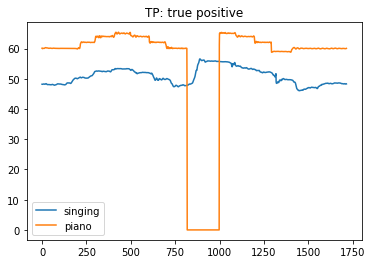

In [90]:
# TP: true positive
clf.predict(histogram_test[1:2])
plt.plot(per_midi_test[1], label="singing")
plt.plot(ref_midi_test[1], label="piano")
plt.legend()
plt.title('TP: true positive')

Text(0.5, 1.0, 'TN: true nagative')

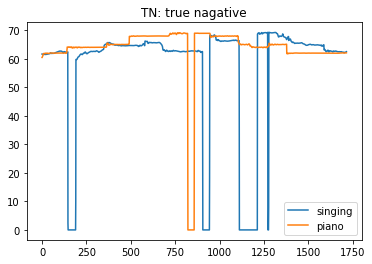

In [91]:
# TN: true nagative
clf.predict(histogram_test[5:6])
plt.plot(per_midi_test[5], label="singing")
plt.plot(ref_midi_test[5], label="piano")
plt.legend()
plt.title('TN: true nagative')

Text(0.5, 1.0, 'FP: false positive')

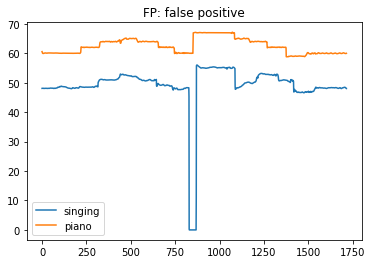

In [92]:
# FP: false positive
clf.predict(histogram_test[11:12])
plt.plot(per_midi_test[11], label="singing")
plt.plot(ref_midi_test[11], label="piano")
plt.legend()
plt.title('FP: false positive')

Text(0.5, 1.0, 'FN: false nagative')

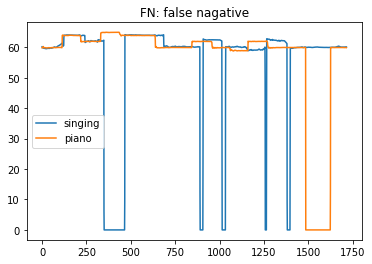

In [93]:
# FN: false nagative
clf.predict(histogram_test[0:1])
plt.plot(per_midi_test[0], label="singing")
plt.plot(ref_midi_test[0], label="piano")
plt.legend()
plt.title('FN: false nagative')

In [56]:
# svm linear
from sklearn import svm
clf = svm.SVC(kernel='linear').fit(histogram_train, y_train)

print("SVM (balanced data):\n")
print("train accuracy: ", clf.score(histogram_train, y_train))
print("\ntest accuracy: ", clf.score(histogram_test, y_test))
y_pred = clf.predict(histogram_test)

from sklearn.metrics import accuracy_score, f1_score
# accuracy_score(y_test, y_pred)
print("test f1-score macro: ", f1_score(y_test, y_pred, average='macro'))
print("test f1-score micro: ", f1_score(y_test, y_pred, average='micro'))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion matrix: \n", cm)

SVM (balanced data):

train accuracy:  0.8870588235294118

test accuracy:  0.6355140186915887
test f1-score macro:  0.635386631716907
test f1-score micro:  0.6355140186915887

Confusion matrix: 
 [[33 16]
 [23 35]]


In [55]:
# decision tree
from sklearn import tree
clf = tree.DecisionTreeClassifier(random_state=0).fit(histogram_train, y_train)

print("Decision tree (balanced data):\n")
print("train accuracy: ", clf.score(histogram_train, y_train))
print("\ntest accuracy: ", clf.score(histogram_test, y_test))
y_pred = clf.predict(histogram_test)

from sklearn.metrics import accuracy_score, f1_score
# accuracy_score(y_test, y_pred)
print("test f1-score macro: ", f1_score(y_test, y_pred, average='macro'))
print("test f1-score micro: ", f1_score(y_test, y_pred, average='micro'))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion matrix: \n", cm)

Decision tree (balanced data):

train accuracy:  1.0

test accuracy:  0.5887850467289719
test f1-score macro:  0.5887491264849756
test f1-score micro:  0.5887850467289719

Confusion matrix: 
 [[32 17]
 [27 31]]


In [49]:
# random forest
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=50, random_state=0).fit(histogram_train, y_train)

print("Random forest (balanced data):\n")
print("train accuracy: ", clf.score(histogram_train, y_train))
print("\ntest accuracy: ", clf.score(histogram_test, y_test))
y_pred = clf.predict(histogram_test)

from sklearn.metrics import accuracy_score, f1_score
# accuracy_score(y_test, y_pred)
print("test f1-score macro: ", f1_score(y_test, y_pred, average='macro'))
print("test f1-score micro: ", f1_score(y_test, y_pred, average='micro'))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion matrix: \n", cm)

Decision tree (balanced data):

train accuracy:  1.0

test accuracy:  0.7009345794392523
test f1-score macro:  0.7002801120448179
test f1-score micro:  0.7009345794392523

Confusion matrix: 
 [[35 14]
 [18 40]]


In [86]:
# MLP
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-3,
                    hidden_layer_sizes=(5,2), random_state=3).fit(histogram_train, y_train)

print("MLP (balanced data):\n")
print("train accuracy: ", clf.score(histogram_train, y_train))
print("\ntest accuracy: ", clf.score(histogram_test, y_test))
y_pred = clf.predict(histogram_test)

from sklearn.metrics import accuracy_score, f1_score
# accuracy_score(y_test, y_pred)
print("test f1-score macro: ", f1_score(y_test, y_pred, average='macro'))
print("test f1-score micro: ", f1_score(y_test, y_pred, average='micro'))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion matrix: \n", cm)

MLP (balanced data):

train accuracy:  0.7223529411764706

test accuracy:  0.7289719626168224
test f1-score macro:  0.7265838399859018
test f1-score micro:  0.7289719626168223

Confusion matrix: 
 [[34 15]
 [14 44]]


## Baseline method results

| Classifier | Train accuracy | Test accuracy |
| :-----:| :----: | :----: |
| Losigtic Regression | 0.785 | 0.700 |
| SVM linear | 0.887 | 0.635 |
| Decision Tree | 1.0 | 0.588 |
| Random Forest | 1.0 | 0.700 |
| Multi Layer Perceptron | 0.722 | 0.728 |